# **COMPONENT 2: CONTEXT-AWARE MOVIE GENRE PREDICTION**

**TABLE OF CONTENTS**
* INTRODUCTION
* DATA LOADING
* DATA PREPROCESSING
* MODEL BUILDING
* MODEL EVALUATION
* CONCLUSIONS & NEXT STEPS

---

## INTRODUCTION

LDOS-CoMoDa is a context-aware movie recommender dataset capturing real user–item interactions enriched with 12 contextual variables (e.g., mood, dominant emotions, emotional response). This allows deep personalization based on user emotions rather than just ratings.

**Source:** andrej.kosir@fe.uni-lj.si  
**Preprocessing notes:** scaling via `StandardScaler`; dataset is relatively clean with minimal noise.

 
 

In [ ]:

#  Load the CoMoDa dataset

```python
import pandas as pd

df = pd.read_csv('LDOS-CoMoDa - Sheet1.csv')
df.head()

* **DATA PREPROCESSING**  
  - Handle missing values.  
  - Scale numerical/contextual features with `StandardScaler`.  
  - Encode the primary genre labels with `LabelEncoder`.

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# target genre - genre1(max class balance)
y = df["genre1"].astype(str)

#prepare feature matrix
drop_cols = [c for c in ["movieID", "date", "genre2", "genre3"] if c in df.columns]
X = df.drop(columns=drop_cols + ["genre1"])

#  Encode the target labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

#  Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


* **MODEL BUILDING**  
  - Split into train/test sets.  
  - Define and train an tuned `MLPClassifier` pipeline.  
  

In [ ]:
#  Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

 #Build & train your MLP for multiclass genre1 prediction
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    early_stopping=True,
    max_iter=300,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

* **SAVE MODEL**  
    

In [ ]:
 #save model
joblib.dump((scaler, mlp, le), "model.pkl")
print("\n✅ Saved model + artifacts to 'model.pkl'")


* **FULL CODES & MODEL EVALUATION**  
   

In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import joblib

# --- Initial Training Script ---
#  Load the CoMoDa sheet
df = pd.read_csv("LDOS-CoMoDa - Sheet1.csv")

# target genre - genre1(max class balance)
y = df["genre1"].astype(str)

#prepare feature matrix
drop_cols = [c for c in ["movieID", "date", "genre2", "genre3"] if c in df.columns]
X = df.drop(columns=drop_cols + ["genre1"])

#  Encode the target labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

#  Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

#  Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

 #Build & train your MLP for multiclass genre1 prediction
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    early_stopping=True,
    max_iter=300,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

 

 

 #save model
joblib.dump((scaler, mlp, le), "model.pkl")
print("\n✅ Saved model + artifacts to 'model.pkl'")


# --- Retraining Function ---
def retrain_model_if_new_batch(new_data_path: str,
                               model_path: str,
                               threshold: int = 100) -> bool:
    """
    Loads an existing model (scaler, MLP, LabelEncoder) tuple from `model_path`,
    checks if `new_data_path` CSV has at least `threshold` rows,
    concatenates with the original LDOS-CoMoDa CSV,
    retrains scaler and MLP on the combined data,
    and overwrites `model_path`.
    Returns True if retraining occurred, else False.
    """
    import pandas as pd
    import numpy as np
    import joblib
    from sklearn.preprocessing import StandardScaler

    # Load new data
    new_df = pd.read_csv(new_data_path)
    if len(new_df) < threshold:
        print(f"Only {len(new_df)} new rows; below threshold {threshold}. No retrain.")
        return False

    # Load original data and combine
    orig_df = pd.read_csv("LDOS-CoMoDa - Sheet1.csv")
    combined = pd.concat([orig_df, new_df], ignore_index=True)

    # Prepare features & target
    y_comb = combined['genre1'].astype(str)
    drop_cols = [c for c in ['movieID','date','genre2','genre3'] if c in combined.columns]
    X_comb = combined.drop(columns=drop_cols + ['genre1'])

    # Load existing model tuple
    data = joblib.load(model_path)
    if isinstance(data, (list, tuple)) and len(data) >= 3:
        scal, model_obj, le_obj = data[:3]
    else:
        raise ValueError(f"Expecting (scaler, model, le) tuple in {model_path}")

    # Encode combined target
    y_enc_comb = le_obj.transform(y_comb)

    # Retrain: new scaler + model fit
    scaler_new = StandardScaler()
    X_scaled_new = scaler_new.fit_transform(X_comb)
    model_obj.fit(X_scaled_new, y_enc_comb)

    # Save updated tuple
    joblib.dump((scaler_new, model_obj, le_obj), model_path)
    print(f"✅ Model retrained and saved to '{model_path}'")
    return True



✅ Saved model + artifacts to 'model.pkl'


=== Full-Dataset Evaluation ===
Accuracy:           0.7047038327526133
Precision (macro):  0.5082621628332
Recall (macro):     0.30360130382827144
F1 Score (macro):   0.3404783844360778

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           1       0.69      0.92      0.79       712
          10       0.62      0.70      0.66       365
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         6
          14       1.00      0.04      0.07        26
          17       1.00      0.21      0.34        29
          18       0.00      0.00      0.00         8
          19       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         2
           3       0.79      0.37      0.51       142
           4       0.87      0.44      0.58       139
           6       0.80      0.29      0.43        68
           7       0.74      0.8

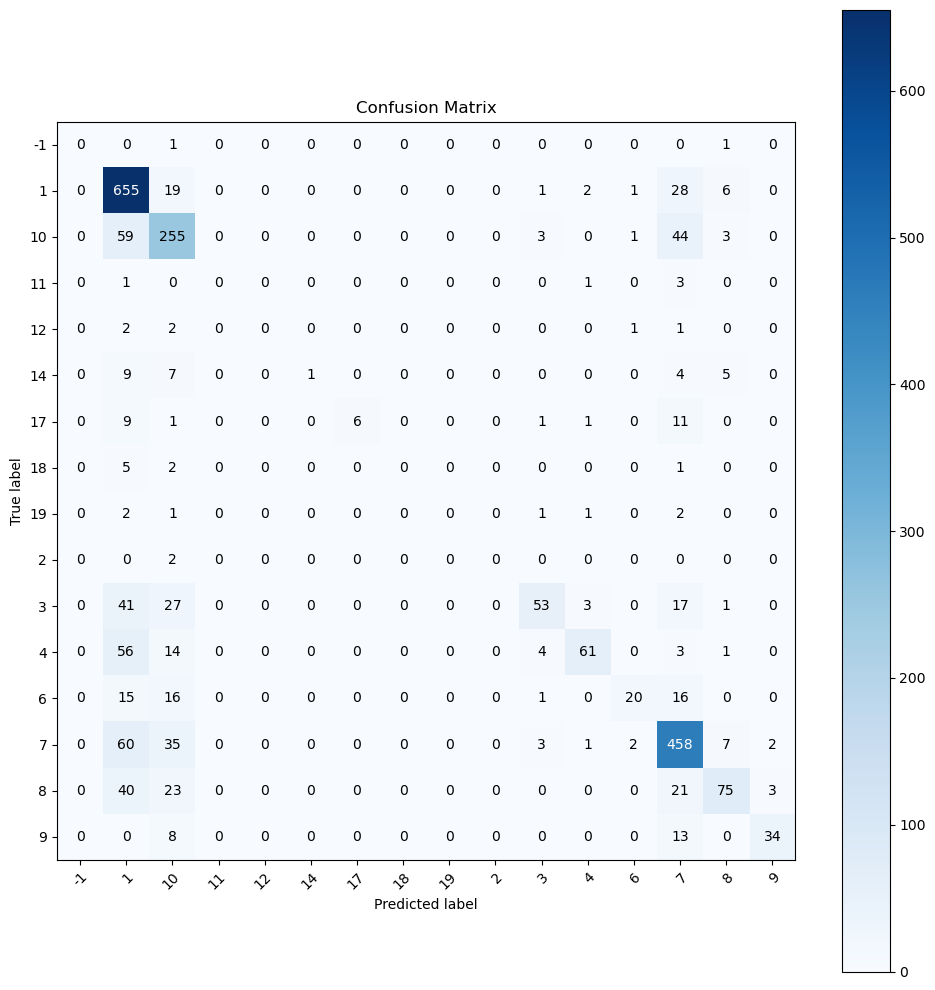

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


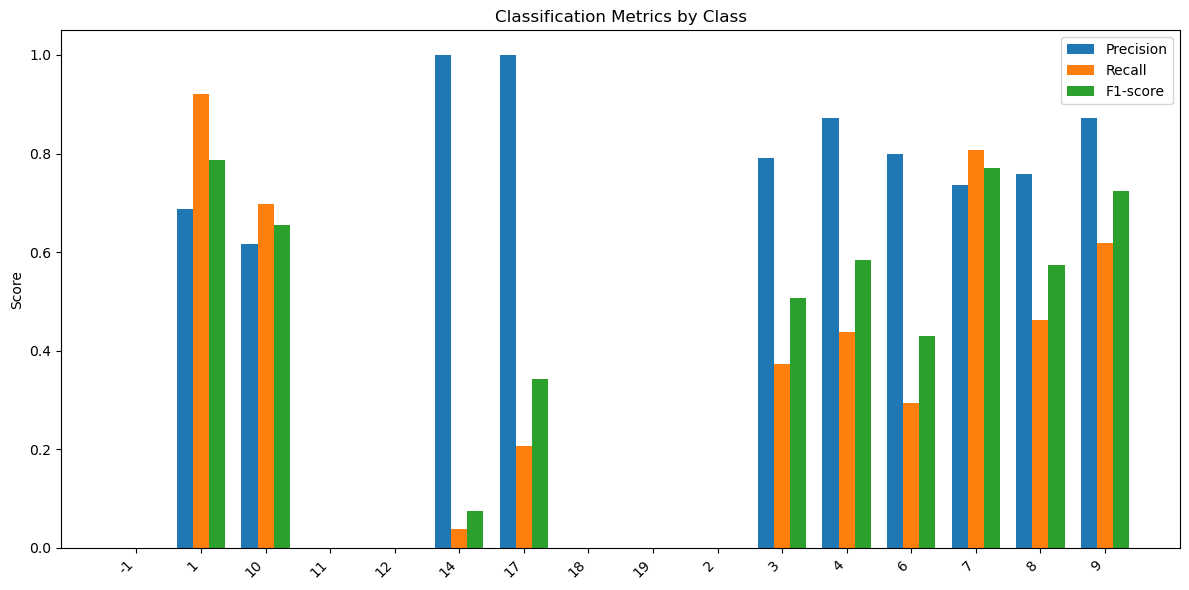

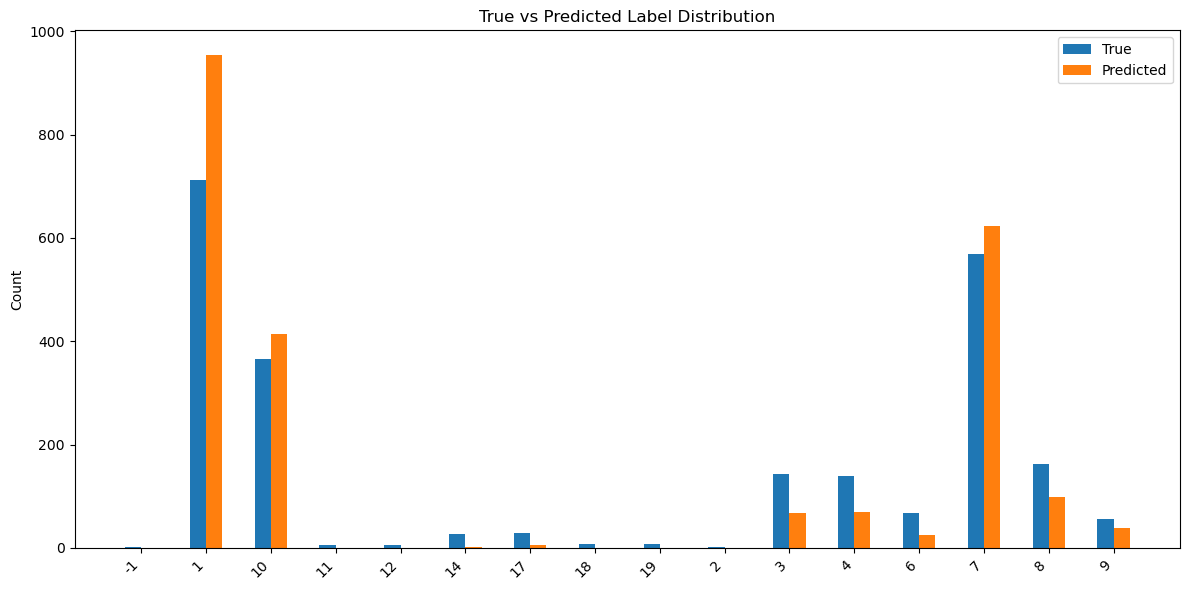

In [28]:
# test_genre1_model_with_visuals.py

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

# 1. Load your saved model artifacts (scaler, trained MLP, label encoder)
scaler, model, le = joblib.load("genre1_mlp.pkl")

# 2. Load the full LDOS-CoMoDa dataset
df = pd.read_csv("LDOS-CoMoDa - Sheet1.csv")

# 3. Prepare features & target exactly as in training
y = df["genre1"].astype(str)
drop_cols = [c for c in ["movieID", "date", "genre2", "genre3"] if c in df.columns]
X = df.drop(columns=drop_cols + ["genre1"])

# 4. Scale features with the loaded scaler
X_scaled = scaler.transform(X)

# 5. Encode the true labels
y_enc = le.transform(y)

# 6. Predict
y_pred = model.predict(X_scaled)

# 7. Compute and print metrics
print("=== Full-Dataset Evaluation ===")
print("Accuracy:          ", accuracy_score(y_enc, y_pred))
print("Precision (macro): ", precision_score(y_enc, y_pred, average="macro", zero_division=0))
print("Recall (macro):    ", recall_score(y_enc, y_pred, average="macro", zero_division=0))
print("F1 Score (macro):  ", f1_score(y_enc, y_pred, average="macro", zero_division=0))
print("\nClassification Report:\n")
print(classification_report(
    y_enc,
    y_pred,
    labels=range(len(le.classes_)),
    target_names=le.classes_,
    zero_division=0
))
 

# --- Visualizations ---

# A. Confusion Matrix Heatmap
cm = confusion_matrix(y_enc, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = le.classes_
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes, yticklabels=classes,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Annotate cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# B. Precision, Recall, F1-score by Class
precision, recall, fscore, support = precision_recall_fscore_support(
    y_enc, y_pred, labels=range(len(classes))
)
x = np.arange(len(classes))
width = 0.25
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, fscore, width, label='F1-score')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Classification Metrics by Class')
ax.legend()
plt.tight_layout()
plt.show()

# C. True vs Predicted Label Distribution
true_counts = np.bincount(y_enc, minlength=len(classes))
pred_counts = np.bincount(y_pred, minlength=len(classes))
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, true_counts, width, label='True')
ax.bar(x + width/2, pred_counts, width, label='Predicted')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('True vs Predicted Label Distribution')
ax.legend()
plt.tight_layout()
plt.show()
